In [22]:
import xlfluor as xlf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import lmfit
import pandas as pd

global DEBUG
DEBUG = True

%matplotlib notebook

## Defining the Cavity

In [13]:
vacuum = xlf.Vacuum()
carbon = xlf.Element(name = 'c', Z= 6, atom_weight = 12.011,density = 2.2*1e3) # the factor 1e3 converts from g/cm3 to Kg/m3
silicon = xlf.Element(name = 'si', Z= 14, atom_weight = 28.086,density = 2.33*1e3)
iron = xlf.Element(name = 'fe', Z = 26, atom_weight=55.845, density=7.87*1e3)
oxygen = xlf.Element(name = 'o', Z = 8, atom_weight=15.999, density=0.143E-02*1e3) # Oxygen density is as gas!!
platinum = xlf.Element(name = 'pt', Z = 78, atom_weight=195.078, density=21.5*1e3)

iron_oxide = xlf.Composite(name = 'fe2o3', elements=[iron, oxygen], density=5.07*1e3, composition =[2,3])

layer_list_custom = [
    xlf.Layer(platinum, 2.8 * 1e-9, density=21.0e3),
    xlf.Layer(carbon, 31.26 * 1e-9, density=1.7e3),
    xlf.Layer(iron_oxide, 3.9 * 1e-9, inelastic_cross=0.4e9, density=4.5e3),
    xlf.Layer(carbon, 34.136 * 1e-9, density=1.6e3),
    xlf.Layer(platinum, 15 * 1e-9, density=21.00e3),
    xlf.Layer(silicon, np.inf, density = 2.33*1e3, final = True)
]

cavity = xlf.Cavity(layer_list_custom)



pt Layer Initiated.
c Layer Initiated.
fe2o3 Layer Initiated.
c Layer Initiated.
pt Layer Initiated.
si Layer Initiated.
Cavity Initiated.


## Loading Experimental Data for Fitting

In [14]:

#### Let us read some experimental data for comparison
keys = ['dt', 'dtz', 'fluor_diode', 'izero_diode', 'refl', 'scanNr',
       'sry', 'sty']
loaded_scan_mat = np.loadtxt('scan_486_wide_angle_diode.txt')
loaded_scan = {}
for i, key in enumerate(keys):
    loaded_scan[key] = loaded_scan_mat[1:,i]

experiment_data = {
    'fluor_diode': xlf.normmax(loaded_scan['fluor_diode']),
    'refl': xlf.normmax(loaded_scan['refl']),
    'angles_in': np.array(loaded_scan['sry']),
    'energies_out': np.array([6400])
}


##### Accounting for experimental offset
# In this dataset it appears that the "sry" motor was offset by 0.025°
experiment_data['angles_in'] = xlf.deg2rad(experiment_data['angles_in'] - 0.025)

## Define Axes
The axis defined here will only be regarded if the same axes are not specified in the experiment data.

In [15]:

energies_in=np.array([7150])
energies_out=np.array([6400])
angles_in  = np.linspace(xlf.deg2rad(0.2),xlf.deg2rad(1.0),100) #np.array([xlf.deg2rad(0.3)])#
angles_out = np.linspace(xlf.deg2rad(0.2),xlf.deg2rad(1.0),100) #np.array(xlf.deg2rad(np.array([0.2,0.3])))#

axes = {'energies_in': energies_in,
        'energies_out': energies_out,
        'angles_in': angles_in,
        'angles_out':angles_out}

## Instantiate Problem and parameters

In [16]:
# Construc the problem object
my_problem = xlf.Problem(cavity, experiment_data = experiment_data, axes=axes,\
                         passive_layer_resolution = 3, active_layer_resolution = 3)

# Get a set of parameters based on the layer list defined above
parameters = cavity.parameters

# Calculate an initial solution
my_problem.solve(cavity, parameters)

# Get the relative intensities of fluorescence and reflectivity
cavity.get_relative_intensities(my_problem)

cavity.set_fit_weigths(weight_refl = 1, weight_fluor = 10)


Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
ProblemSolution Initiated.
Based on the Initial fit, setting relative intensity of refl and fluor 
 to 0.9408453228655563 and 0.0013716384068637795, respectively


<IPython.core.display.Javascript object>


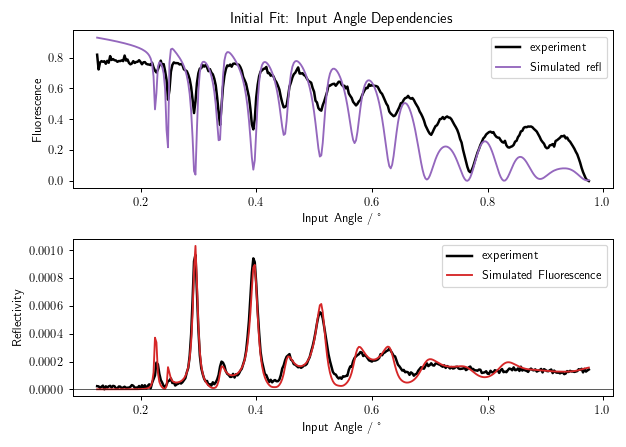

In [23]:
###################################################
##### Diode trace plots
###################################################
angles_in = xlf.rad2deg(my_problem.angles_in)
model_fluor = xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)
model_refl = np.mean(xlf.abs2(my_problem.reflectivity),0)

exp_fluor = my_problem.experiment['fluor_diode']*cavity.parameters['I_fluorescence']
exp_refl = my_problem.experiment['refl']*cavity.parameters['I_reflectivity']

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7, 5))
ax1.set_title(f'Initial Fit: Input Angle Dependencies')

plt.sca(ax1)
ax1.plot(angles_in, exp_refl, c='k', lw=2,label = 'experiment')
ax1.plot(angles_in, model_refl, 'C4-', label='Simulated refl')

plt.ylabel('Normalized Intensity / arb. u.')
plt.xlabel('Input Angle / °')
plt.ylabel('Fluorescence')
plt.legend()

plt.sca(ax2)
ax2.plot(angles_in, exp_fluor, c='k', lw=2,label = 'experiment')
ax2.plot(angles_in, model_fluor, c='C3',
         label='Simulated Fluorescence')
plt.xlabel('Input Angle / °')
plt.legend()
plt.ylabel('Reflectivity')
plt.axhline(c='k', lw=.5)
plt.tight_layout()


## Optimization

### Create the logger for following fit parameters and plotting

In [29]:
        
logger = xlf.FitLogger(my_problem, parameters, maxiter = 10000)

TypeError: __init__() got an unexpected keyword argument 'maxiter'

In [ ]:
### Run a minimizer on the cost function

In [30]:
minimizer = lmfit.Minimizer(xlf.cost_function, params=parameters,\
                            fcn_args= (my_problem,),\
                            iter_cb = logger.logging)#xlf.fit_monitoring

result = minimizer.minimize(method = 'leastsq')#

lmfit.report_fit(result)
plt.show()

{'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
Iteration -1 complete. Residuals: {'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
{'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
Iteration 0 complete. Residuals: {'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
{'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
Iteration 1 complete. Residuals: {'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
{'Refl': 45.63603344442173, 'Fluor': 175.83231131177712}
Iteration 2 complete. Residuals: {'Refl': 45.63603344442173, 'Fluor': 175.83231131177712}
{'Refl': 45.63603368029611, 'Fluor': 175.83230941112387}
Iteration 3 complete. Residuals: {'Refl': 45.63603368029611, 'Fluor': 175.83230941112387}
{'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
Iteration 4 complete. Residuals: {'Refl': 45.636033696117735, 'Fluor': 175.83230936574392}
{'Refl': 45.63603373075335, 'Fluor': 175.83230801990078}
Iteration 5 complete. Residuals: {'Refl': 45.6360337

{'Refl': 53.902822647017516, 'Fluor': 101.34193507629587}
Iteration 62 complete. Residuals: {'Refl': 53.902822647017516, 'Fluor': 101.34193507629587}
{'Refl': 53.902822657296184, 'Fluor': 101.34193519214945}
Iteration 63 complete. Residuals: {'Refl': 53.902822657296184, 'Fluor': 101.34193519214945}
{'Refl': 53.90282264455207, 'Fluor': 101.34193458696392}
Iteration 64 complete. Residuals: {'Refl': 53.90282264455207, 'Fluor': 101.34193458696392}
{'Refl': 53.902822657296184, 'Fluor': 101.34193519214945}
Iteration 65 complete. Residuals: {'Refl': 53.902822657296184, 'Fluor': 101.34193519214945}
{'Refl': 53.902822657324144, 'Fluor': 101.34193521789496}
Iteration 66 complete. Residuals: {'Refl': 53.902822657324144, 'Fluor': 101.34193521789496}
{'Refl': 53.90282267463637, 'Fluor': 101.34193521103877}
Iteration 67 complete. Residuals: {'Refl': 53.90282267463637, 'Fluor': 101.34193521103877}
{'Refl': 53.902822657139865, 'Fluor': 101.34193518813387}
Iteration 68 complete. Residuals: {'Refl': 53.

{'Refl': 53.62566233035815, 'Fluor': 99.97400184335066}
Iteration 118 complete. Residuals: {'Refl': 53.62566233035815, 'Fluor': 99.97400184335066}
{'Refl': 53.625662305191604, 'Fluor': 99.9740015659038}
Iteration 119 complete. Residuals: {'Refl': 53.625662305191604, 'Fluor': 99.9740015659038}
{'Refl': 53.62566232482981, 'Fluor': 99.97400128437216}
Iteration 120 complete. Residuals: {'Refl': 53.62566232482981, 'Fluor': 99.97400128437216}
{'Refl': 53.62566231341258, 'Fluor': 99.97400242489906}
Iteration 121 complete. Residuals: {'Refl': 53.62566231341258, 'Fluor': 99.97400242489906}
{'Refl': 53.62566232482981, 'Fluor': 99.97400128437216}
Iteration 122 complete. Residuals: {'Refl': 53.62566232482981, 'Fluor': 99.97400128437216}
{'Refl': 53.6256623250768, 'Fluor': 99.97400131831668}
Iteration 123 complete. Residuals: {'Refl': 53.6256623250768, 'Fluor': 99.97400131831668}
{'Refl': 53.62566233746399, 'Fluor': 99.97400129979786}
Iteration 124 complete. Residuals: {'Refl': 53.62566233746399, '

{'Refl': 53.532256360432186, 'Fluor': 99.10616994815632}
Iteration 174 complete. Residuals: {'Refl': 53.532256360432186, 'Fluor': 99.10616994815632}
{'Refl': 53.53225636465638, 'Fluor': 99.10617054468838}
Iteration 175 complete. Residuals: {'Refl': 53.53225636465638, 'Fluor': 99.10617054468838}
{'Refl': 53.53225635989147, 'Fluor': 99.10616995642955}
Iteration 176 complete. Residuals: {'Refl': 53.53225635989147, 'Fluor': 99.10616995642955}
{'Refl': 53.532256360432186, 'Fluor': 99.10616994815632}
Iteration 177 complete. Residuals: {'Refl': 53.532256360432186, 'Fluor': 99.10616994815632}
{'Refl': 53.53225634916663, 'Fluor': 99.10617124799967}
Iteration 178 complete. Residuals: {'Refl': 53.53225634916663, 'Fluor': 99.10617124799967}
{'Refl': 53.532256360432186, 'Fluor': 99.10616994815632}
Iteration 179 complete. Residuals: {'Refl': 53.532256360432186, 'Fluor': 99.10616994815632}
{'Refl': 53.53225636078109, 'Fluor': 99.10617002592016}
Iteration 180 complete. Residuals: {'Refl': 53.532256360

{'Refl': 53.45759144672778, 'Fluor': 98.7690562063493}
Iteration 230 complete. Residuals: {'Refl': 53.45759144672778, 'Fluor': 98.7690562063493}
{'Refl': 53.45759145063714, 'Fluor': 98.76905680486645}
Iteration 231 complete. Residuals: {'Refl': 53.45759145063714, 'Fluor': 98.76905680486645}
{'Refl': 53.457591446717615, 'Fluor': 98.76905620650217}
Iteration 232 complete. Residuals: {'Refl': 53.457591446717615, 'Fluor': 98.76905620650217}
{'Refl': 53.45759144672778, 'Fluor': 98.7690562063493}
Iteration 233 complete. Residuals: {'Refl': 53.45759144672778, 'Fluor': 98.7690562063493}
{'Refl': 53.457591435438616, 'Fluor': 98.76905756206187}
Iteration 234 complete. Residuals: {'Refl': 53.457591435438616, 'Fluor': 98.76905756206187}
{'Refl': 53.45759144672778, 'Fluor': 98.7690562063493}
Iteration 235 complete. Residuals: {'Refl': 53.45759144672778, 'Fluor': 98.7690562063493}
{'Refl': 53.457591447146314, 'Fluor': 98.76905632304623}
Iteration 236 complete. Residuals: {'Refl': 53.457591447146314,

{'Refl': 53.30674550727055, 'Fluor': 98.18421729423218}
Iteration 293 complete. Residuals: {'Refl': 53.30674550727055, 'Fluor': 98.18421729423218}
{'Refl': 53.30674549892648, 'Fluor': 98.18421762444287}
Iteration 294 complete. Residuals: {'Refl': 53.30674549892648, 'Fluor': 98.18421762444287}
{'Refl': 53.306745499699076, 'Fluor': 98.18421727429833}
Iteration 295 complete. Residuals: {'Refl': 53.306745499699076, 'Fluor': 98.18421727429833}
{'Refl': 53.30674549978292, 'Fluor': 98.18421727398913}
Iteration 296 complete. Residuals: {'Refl': 53.30674549978292, 'Fluor': 98.18421727398913}
{'Refl': 53.30674549942996, 'Fluor': 98.18421727577076}
Iteration 297 complete. Residuals: {'Refl': 53.30674549942996, 'Fluor': 98.18421727577076}
{'Refl': 53.306745499699076, 'Fluor': 98.18421227120928}
Iteration 298 complete. Residuals: {'Refl': 53.306745499699076, 'Fluor': 98.18421227120928}
{'Refl': 53.30674407613424, 'Fluor': 98.18421727429833}
Iteration 299 complete. Residuals: {'Refl': 53.30674407613

{'Refl': 53.174264085031375, 'Fluor': 97.54315470465679}
Iteration 349 complete. Residuals: {'Refl': 53.174264085031375, 'Fluor': 97.54315470465679}
{'Refl': 53.17426408960955, 'Fluor': 97.54315449412022}
Iteration 350 complete. Residuals: {'Refl': 53.17426408960955, 'Fluor': 97.54315449412022}
{'Refl': 53.17426408365176, 'Fluor': 97.5431548823016}
Iteration 351 complete. Residuals: {'Refl': 53.17426408365176, 'Fluor': 97.5431548823016}
{'Refl': 53.17426408451359, 'Fluor': 97.54315447414814}
Iteration 352 complete. Residuals: {'Refl': 53.17426408451359, 'Fluor': 97.54315447414814}
{'Refl': 53.17426408449454, 'Fluor': 97.54315447421186}
Iteration 353 complete. Residuals: {'Refl': 53.17426408449454, 'Fluor': 97.54315447421186}
{'Refl': 53.17426408813655, 'Fluor': 97.5431544418285}
Iteration 354 complete. Residuals: {'Refl': 53.17426408813655, 'Fluor': 97.5431544418285}
{'Refl': 53.17426408451359, 'Fluor': 97.54314956131242}
Iteration 355 complete. Residuals: {'Refl': 53.17426408451359, '

{'Refl': 53.17951803098521, 'Fluor': 97.11624787677522}
Iteration 412 complete. Residuals: {'Refl': 53.17951803098521, 'Fluor': 97.11624787677522}
{'Refl': 53.17951661181149, 'Fluor': 97.1162526350038}
Iteration 413 complete. Residuals: {'Refl': 53.17951661181149, 'Fluor': 97.1162526350038}
{'Refl': 53.17728088115559, 'Fluor': 97.0956856227682}
Iteration 414 complete. Residuals: {'Refl': 53.17728088115559, 'Fluor': 97.0956856227682}
{'Refl': 53.17728087189762, 'Fluor': 97.09568616806676}
Iteration 415 complete. Residuals: {'Refl': 53.17728087189762, 'Fluor': 97.09568616806676}
{'Refl': 53.1772808811547, 'Fluor': 97.0956856227766}
Iteration 416 complete. Residuals: {'Refl': 53.1772808811547, 'Fluor': 97.0956856227766}
{'Refl': 53.17728088115559, 'Fluor': 97.0956856227682}
Iteration 417 complete. Residuals: {'Refl': 53.17728088115559, 'Fluor': 97.0956856227682}
{'Refl': 53.17728086944538, 'Fluor': 97.0956868747813}
Iteration 418 complete. Residuals: {'Refl': 53.17728086944538, 'Fluor': 9

{'Refl': 53.170019345154856, 'Fluor': 97.0460943021049}
Iteration 468 complete. Residuals: {'Refl': 53.170019345154856, 'Fluor': 97.0460943021049}
{'Refl': 53.17001792646489, 'Fluor': 97.04609908082992}
Iteration 469 complete. Residuals: {'Refl': 53.17001792646489, 'Fluor': 97.04609908082992}
{'Refl': 53.16753075770906, 'Fluor': 97.03022008977625}
Iteration 470 complete. Residuals: {'Refl': 53.16753075770906, 'Fluor': 97.03022008977625}
{'Refl': 53.167530748388316, 'Fluor': 97.03022063480758}
Iteration 471 complete. Residuals: {'Refl': 53.167530748388316, 'Fluor': 97.03022063480758}
{'Refl': 53.167530757709144, 'Fluor': 97.03022008977453}
Iteration 472 complete. Residuals: {'Refl': 53.167530757709144, 'Fluor': 97.03022008977453}
{'Refl': 53.16753075770906, 'Fluor': 97.03022008977625}
Iteration 473 complete. Residuals: {'Refl': 53.16753075770906, 'Fluor': 97.03022008977625}
{'Refl': 53.16753074598833, 'Fluor': 97.03022133935464}
Iteration 474 complete. Residuals: {'Refl': 53.16753074598

{'Refl': 53.16003739403316, 'Fluor': 96.98276945941798}
Iteration 524 complete. Residuals: {'Refl': 53.16003739403316, 'Fluor': 96.98276945941798}
{'Refl': 53.16003597584348, 'Fluor': 96.9827742585911}
Iteration 525 complete. Residuals: {'Refl': 53.16003597584348, 'Fluor': 96.9827742585911}
{'Refl': 53.15754593153201, 'Fluor': 96.96701934860359}
Iteration 526 complete. Residuals: {'Refl': 53.15754593153201, 'Fluor': 96.96701934860359}
{'Refl': 53.15754592214776, 'Fluor': 96.96701989336779}
Iteration 527 complete. Residuals: {'Refl': 53.15754592214776, 'Fluor': 96.96701989336779}
{'Refl': 53.157545931532, 'Fluor': 96.96701934860403}
Iteration 528 complete. Residuals: {'Refl': 53.157545931532, 'Fluor': 96.96701934860403}
{'Refl': 53.15754593153201, 'Fluor': 96.96701934860359}
Iteration 529 complete. Residuals: {'Refl': 53.15754593153201, 'Fluor': 96.96701934860359}
{'Refl': 53.15754591979934, 'Fluor': 96.96702059561098}
Iteration 530 complete. Residuals: {'Refl': 53.15754591979934, 'Fluo

{'Refl': 53.14803718565718, 'Fluor': 96.94620803251311}
Iteration 580 complete. Residuals: {'Refl': 53.14803718565718, 'Fluor': 96.94620803251311}
{'Refl': 53.14803576805802, 'Fluor': 96.94621285370789}
Iteration 581 complete. Residuals: {'Refl': 53.14803576805802, 'Fluor': 96.94621285370789}
{'Refl': 53.14451196624226, 'Fluor': 96.95688220392536}
Iteration 582 complete. Residuals: {'Refl': 53.14451196624226, 'Fluor': 96.95688220392536}
{'Refl': 53.144511956780484, 'Fluor': 96.95688274792042}
Iteration 583 complete. Residuals: {'Refl': 53.144511956780484, 'Fluor': 96.95688274792042}
{'Refl': 53.144511966242206, 'Fluor': 96.95688220392712}
Iteration 584 complete. Residuals: {'Refl': 53.144511966242206, 'Fluor': 96.95688220392712}
{'Refl': 53.14451196624226, 'Fluor': 96.95688220392536}
Iteration 585 complete. Residuals: {'Refl': 53.14451196624226, 'Fluor': 96.95688220392536}
{'Refl': 53.14451195449531, 'Fluor': 96.9568834477575}
Iteration 586 complete. Residuals: {'Refl': 53.144511954495

{'Refl': 53.13595052831097, 'Fluor': 96.92085983745537}
Iteration 636 complete. Residuals: {'Refl': 53.13595052831097, 'Fluor': 96.92085983745537}
{'Refl': 53.1359491112975, 'Fluor': 96.92086468310656}
Iteration 637 complete. Residuals: {'Refl': 53.1359491112975, 'Fluor': 96.92086468310656}
{'Refl': 53.1332406900808, 'Fluor': 96.9047084965358}
Iteration 638 complete. Residuals: {'Refl': 53.1332406900808, 'Fluor': 96.9047084965358}
{'Refl': 53.133240680557066, 'Fluor': 96.90470904035226}
Iteration 639 complete. Residuals: {'Refl': 53.133240680557066, 'Fluor': 96.90470904035226}
{'Refl': 53.1332406900808, 'Fluor': 96.90470849653295}
Iteration 640 complete. Residuals: {'Refl': 53.1332406900808, 'Fluor': 96.90470849653295}
{'Refl': 53.1332406900808, 'Fluor': 96.9047084965358}
Iteration 641 complete. Residuals: {'Refl': 53.1332406900808, 'Fluor': 96.9047084965358}
{'Refl': 53.13324067831853, 'Fluor': 96.90470973725635}
Iteration 642 complete. Residuals: {'Refl': 53.13324067831853, 'Fluor': 

{'Refl': 53.12522026965008, 'Fluor': 96.8561093400078}
Iteration 692 complete. Residuals: {'Refl': 53.12522026965008, 'Fluor': 96.8561093400078}
{'Refl': 53.125218853167496, 'Fluor': 96.85611420737874}
Iteration 693 complete. Residuals: {'Refl': 53.125218853167496, 'Fluor': 96.85611420737874}
{'Refl': 53.12260391356031, 'Fluor': 96.84002982364231}
Iteration 694 complete. Residuals: {'Refl': 53.12260391356031, 'Fluor': 96.84002982364231}
{'Refl': 53.12260390073983, 'Fluor': 96.84003036729001}
Iteration 695 complete. Residuals: {'Refl': 53.12260390073983, 'Fluor': 96.84003036729001}
{'Refl': 53.1226039135603, 'Fluor': 96.84002982364427}
Iteration 696 complete. Residuals: {'Refl': 53.1226039135603, 'Fluor': 96.84002982364427}
{'Refl': 53.12260391356031, 'Fluor': 96.84002982364231}
Iteration 697 complete. Residuals: {'Refl': 53.12260391356031, 'Fluor': 96.84002982364231}
{'Refl': 53.12260390193768, 'Fluor': 96.8400310609926}
Iteration 698 complete. Residuals: {'Refl': 53.12260390193768, 'F

{'Refl': 53.11525664058384, 'Fluor': 96.79213019318027}
Iteration 748 complete. Residuals: {'Refl': 53.11525664058384, 'Fluor': 96.79213019318027}
{'Refl': 53.11525523862842, 'Fluor': 96.79213508174615}
Iteration 749 complete. Residuals: {'Refl': 53.11525523862842, 'Fluor': 96.79213508174615}
{'Refl': 53.11282693215369, 'Fluor': 96.77630022068095}
Iteration 750 complete. Residuals: {'Refl': 53.11282693215369, 'Fluor': 96.77630022068095}
{'Refl': 53.11282691927569, 'Fluor': 96.77630076413276}
Iteration 751 complete. Residuals: {'Refl': 53.11282691927569, 'Fluor': 96.77630076413276}
{'Refl': 53.11282693215371, 'Fluor': 96.77630022068192}
Iteration 752 complete. Residuals: {'Refl': 53.11282693215371, 'Fluor': 96.77630022068192}
{'Refl': 53.11282693215369, 'Fluor': 96.77630022068095}
Iteration 753 complete. Residuals: {'Refl': 53.11282693215369, 'Fluor': 96.77630022068095}
{'Refl': 53.1128269205181, 'Fluor': 96.77630145449467}
Iteration 754 complete. Residuals: {'Refl': 53.1128269205181, '

{'Refl': 53.105594545023266, 'Fluor': 96.72917655843852}
Iteration 804 complete. Residuals: {'Refl': 53.105594545023266, 'Fluor': 96.72917655843852}
{'Refl': 53.10559314355159, 'Fluor': 96.72918146770671}
Iteration 805 complete. Residuals: {'Refl': 53.10559314355159, 'Fluor': 96.72918146770671}
{'Refl': 53.103202870195474, 'Fluor': 96.71359858347269}
Iteration 806 complete. Residuals: {'Refl': 53.103202870195474, 'Fluor': 96.71359858347269}
{'Refl': 53.10320285726037, 'Fluor': 96.71359912673023}
Iteration 807 complete. Residuals: {'Refl': 53.10320285726037, 'Fluor': 96.71359912673023}
{'Refl': 53.10320287019543, 'Fluor': 96.71359858347148}
Iteration 808 complete. Residuals: {'Refl': 53.10320287019543, 'Fluor': 96.71359858347148}
{'Refl': 53.103202870195474, 'Fluor': 96.71359858347269}
Iteration 809 complete. Residuals: {'Refl': 53.103202870195474, 'Fluor': 96.71359858347269}
{'Refl': 53.103202858547256, 'Fluor': 96.7135998136051}
Iteration 810 complete. Residuals: {'Refl': 53.103202858

{'Refl': 53.09609289690547, 'Fluor': 96.66727575858309}
Iteration 860 complete. Residuals: {'Refl': 53.09609289690547, 'Fluor': 96.66727575858309}
{'Refl': 53.09609149590949, 'Fluor': 96.6672806880728}
Iteration 861 complete. Residuals: {'Refl': 53.09609149590949, 'Fluor': 96.6672806880728}
{'Refl': 53.093740979253624, 'Fluor': 96.65196529062666}
Iteration 862 complete. Residuals: {'Refl': 53.093740979253624, 'Fluor': 96.65196529062666}
{'Refl': 53.093740966262665, 'Fluor': 96.65196583370046}
Iteration 863 complete. Residuals: {'Refl': 53.093740966262665, 'Fluor': 96.65196583370046}
{'Refl': 53.09374097925351, 'Fluor': 96.6519652906279}
Iteration 864 complete. Residuals: {'Refl': 53.09374097925351, 'Fluor': 96.6519652906279}
{'Refl': 53.093740979253624, 'Fluor': 96.65196529062666}
Iteration 865 complete. Residuals: {'Refl': 53.093740979253624, 'Fluor': 96.65196529062666}
{'Refl': 53.09374096759305, 'Fluor': 96.65196651694869}
Iteration 866 complete. Residuals: {'Refl': 53.0937409675930

{'Refl': 53.08443875674782, 'Fluor': 96.59345647790977}
Iteration 922 complete. Residuals: {'Refl': 53.08443875674782, 'Fluor': 96.59345647790977}
{'Refl': 53.0844387684205, 'Fluor': 96.5934553346425}
Iteration 923 complete. Residuals: {'Refl': 53.0844387684205, 'Fluor': 96.5934553346425}
{'Refl': 53.084438769197114, 'Fluor': 96.59345558552741}
Iteration 924 complete. Residuals: {'Refl': 53.084438769197114, 'Fluor': 96.59345558552741}
{'Refl': 53.0844387714498, 'Fluor': 96.59345535038918}
Iteration 925 complete. Residuals: {'Refl': 53.0844387714498, 'Fluor': 96.59345535038918}
{'Refl': 53.08443876753402, 'Fluor': 96.59345575703571}
Iteration 926 complete. Residuals: {'Refl': 53.08443876753402, 'Fluor': 96.59345575703571}
{'Refl': 53.0844387684205, 'Fluor': 96.5934553346425}
Iteration 927 complete. Residuals: {'Refl': 53.0844387684205, 'Fluor': 96.5934553346425}
{'Refl': 53.084438768420014, 'Fluor': 96.59345533464449}
Iteration 928 complete. Residuals: {'Refl': 53.084438768420014, 'Fluo

{'Refl': 53.07529455945632, 'Fluor': 96.53854999873423}
Iteration 978 complete. Residuals: {'Refl': 53.07529455945632, 'Fluor': 96.53854999873423}
{'Refl': 53.07529457114088, 'Fluor': 96.53854885918038}
Iteration 979 complete. Residuals: {'Refl': 53.07529457114088, 'Fluor': 96.53854885918038}
{'Refl': 53.075294571922846, 'Fluor': 96.53854911284535}
Iteration 980 complete. Residuals: {'Refl': 53.075294571922846, 'Fluor': 96.53854911284535}
{'Refl': 53.075294574056414, 'Fluor': 96.5385488747502}
Iteration 981 complete. Residuals: {'Refl': 53.075294574056414, 'Fluor': 96.5385488747502}
{'Refl': 53.07529457024069, 'Fluor': 96.53854928575235}
Iteration 982 complete. Residuals: {'Refl': 53.07529457024069, 'Fluor': 96.53854928575235}
{'Refl': 53.07529457114088, 'Fluor': 96.53854885918038}
Iteration 983 complete. Residuals: {'Refl': 53.07529457114088, 'Fluor': 96.53854885918038}
{'Refl': 53.07529457114057, 'Fluor': 96.53854885918017}
Iteration 984 complete. Residuals: {'Refl': 53.0752945711405

{'Refl': 53.06632600610194, 'Fluor': 96.48465030263569}
Iteration 1034 complete. Residuals: {'Refl': 53.06632600610194, 'Fluor': 96.48465030263569}
{'Refl': 53.06632601775344, 'Fluor': 96.48464916687907}
Iteration 1035 complete. Residuals: {'Refl': 53.06632601775344, 'Fluor': 96.48464916687907}
{'Refl': 53.06632601853885, 'Fluor': 96.48464942319133}
Iteration 1036 complete. Residuals: {'Refl': 53.06632601853885, 'Fluor': 96.48464942319133}
{'Refl': 53.066326020451406, 'Fluor': 96.48464918223954}
Iteration 1037 complete. Residuals: {'Refl': 53.066326020451406, 'Fluor': 96.48464918223954}
{'Refl': 53.06632601686746, 'Fluor': 96.48464959746565}
Iteration 1038 complete. Residuals: {'Refl': 53.06632601686746, 'Fluor': 96.48464959746565}
{'Refl': 53.06632601775344, 'Fluor': 96.48464916687907}
Iteration 1039 complete. Residuals: {'Refl': 53.06632601775344, 'Fluor': 96.48464916687907}
{'Refl': 53.066326017753276, 'Fluor': 96.48464916687965}
Iteration 1040 complete. Residuals: {'Refl': 53.06632

{'Refl': 53.06473947705679, 'Fluor': 96.30918487982629}
Iteration 1090 complete. Residuals: {'Refl': 53.06473947705679, 'Fluor': 96.30918487982629}
{'Refl': 53.064739488717294, 'Fluor': 96.3091837468717}
Iteration 1091 complete. Residuals: {'Refl': 53.064739488717294, 'Fluor': 96.3091837468717}
{'Refl': 53.06473948950783, 'Fluor': 96.30918400585317}
Iteration 1092 complete. Residuals: {'Refl': 53.06473948950783, 'Fluor': 96.30918400585317}
{'Refl': 53.0647394913225, 'Fluor': 96.30918376203795}
Iteration 1093 complete. Residuals: {'Refl': 53.0647394913225, 'Fluor': 96.30918376203795}
{'Refl': 53.06473948782042, 'Fluor': 96.30918418117628}
Iteration 1094 complete. Residuals: {'Refl': 53.06473948782042, 'Fluor': 96.30918418117628}
{'Refl': 53.064739488717294, 'Fluor': 96.3091837468717}
Iteration 1095 complete. Residuals: {'Refl': 53.064739488717294, 'Fluor': 96.3091837468717}
{'Refl': 53.06473948871715, 'Fluor': 96.30918374687224}
Iteration 1096 complete. Residuals: {'Refl': 53.0647394887

{'Refl': 53.051861673700124, 'Fluor': 96.27919605427492}
Iteration 1146 complete. Residuals: {'Refl': 53.051861673700124, 'Fluor': 96.27919605427492}
{'Refl': 53.0518616620303, 'Fluor': 96.27919718171715}
Iteration 1147 complete. Residuals: {'Refl': 53.0518616620303, 'Fluor': 96.27919718171715}
{'Refl': 53.051861673700124, 'Fluor': 96.27919605427492}
Iteration 1148 complete. Residuals: {'Refl': 53.051861673700124, 'Fluor': 96.27919605427492}
{'Refl': 53.051861674497076, 'Fluor': 96.27919631569695}
Iteration 1149 complete. Residuals: {'Refl': 53.051861674497076, 'Fluor': 96.27919631569695}
{'Refl': 53.0518616761931, 'Fluor': 96.27919606919424}
Iteration 1150 complete. Residuals: {'Refl': 53.0518616761931, 'Fluor': 96.27919606919424}
{'Refl': 53.05186167278811, 'Fluor': 96.27919649281047}
Iteration 1151 complete. Residuals: {'Refl': 53.05186167278811, 'Fluor': 96.27919649281047}
{'Refl': 53.051861673700124, 'Fluor': 96.27919605427492}
Iteration 1152 complete. Residuals: {'Refl': 53.05186

{'Refl': 53.044608966461375, 'Fluor': 96.22632790862241}
Iteration 1202 complete. Residuals: {'Refl': 53.044608966461375, 'Fluor': 96.22632790862241}
{'Refl': 53.044608954781324, 'Fluor': 96.2263290192359}
Iteration 1203 complete. Residuals: {'Refl': 53.044608954781324, 'Fluor': 96.2263290192359}
{'Refl': 53.044608966461375, 'Fluor': 96.22632790862241}
Iteration 1204 complete. Residuals: {'Refl': 53.044608966461375, 'Fluor': 96.22632790862241}
{'Refl': 53.04460896726202, 'Fluor': 96.22632816782432}
Iteration 1205 complete. Residuals: {'Refl': 53.04460896726202, 'Fluor': 96.22632816782432}
{'Refl': 53.04460896886264, 'Fluor': 96.22632792373395}
Iteration 1206 complete. Residuals: {'Refl': 53.04460896886264, 'Fluor': 96.22632792373395}
{'Refl': 53.04460896553784, 'Fluor': 96.22632834346716}
Iteration 1207 complete. Residuals: {'Refl': 53.04460896553784, 'Fluor': 96.22632834346716}
{'Refl': 53.044608966461375, 'Fluor': 96.22632790862241}
Iteration 1208 complete. Residuals: {'Refl': 53.044

{'Refl': 53.03790386586658, 'Fluor': 96.17985458637999}
Iteration 1258 complete. Residuals: {'Refl': 53.03790386586658, 'Fluor': 96.17985458637999}
{'Refl': 53.037903853739046, 'Fluor': 96.17985569345683}
Iteration 1259 complete. Residuals: {'Refl': 53.037903853739046, 'Fluor': 96.17985569345683}
{'Refl': 53.03790386586658, 'Fluor': 96.17985458637999}
Iteration 1260 complete. Residuals: {'Refl': 53.03790386586658, 'Fluor': 96.17985458637999}
{'Refl': 53.037903865817206, 'Fluor': 96.17985484748215}
Iteration 1261 complete. Residuals: {'Refl': 53.037903865817206, 'Fluor': 96.17985484748215}
{'Refl': 53.03790386823229, 'Fluor': 96.1798546012015}
Iteration 1262 complete. Residuals: {'Refl': 53.03790386823229, 'Fluor': 96.1798546012015}
{'Refl': 53.037903864184095, 'Fluor': 96.17985502422883}
Iteration 1263 complete. Residuals: {'Refl': 53.037903864184095, 'Fluor': 96.17985502422883}
{'Refl': 53.03790386586658, 'Fluor': 96.17985458637999}
Iteration 1264 complete. Residuals: {'Refl': 53.0379

{'Refl': 53.031810908598615, 'Fluor': 96.13513279986662}
Iteration 1314 complete. Residuals: {'Refl': 53.031810908598615, 'Fluor': 96.13513279986662}
{'Refl': 53.03181089654703, 'Fluor': 96.1351339033763}
Iteration 1315 complete. Residuals: {'Refl': 53.03181089654703, 'Fluor': 96.1351339033763}
{'Refl': 53.031810908598615, 'Fluor': 96.13513279986662}
Iteration 1316 complete. Residuals: {'Refl': 53.031810908598615, 'Fluor': 96.13513279986662}
{'Refl': 53.031810908568886, 'Fluor': 96.13513306279204}
Iteration 1317 complete. Residuals: {'Refl': 53.031810908568886, 'Fluor': 96.13513306279204}
{'Refl': 53.03181091074144, 'Fluor': 96.13513281438509}
Iteration 1318 complete. Residuals: {'Refl': 53.03181091074144, 'Fluor': 96.13513281438509}
{'Refl': 53.031810906933366, 'Fluor': 96.13513324062191}
Iteration 1319 complete. Residuals: {'Refl': 53.031810906933366, 'Fluor': 96.13513324062191}
{'Refl': 53.031810908598615, 'Fluor': 96.13513279986662}
Iteration 1320 complete. Residuals: {'Refl': 53.0

{'Refl': 53.02599001353549, 'Fluor': 96.09135385304825}
Iteration 1370 complete. Residuals: {'Refl': 53.02599001353549, 'Fluor': 96.09135385304825}
{'Refl': 53.02599000147912, 'Fluor': 96.09135495295887}
Iteration 1371 complete. Residuals: {'Refl': 53.02599000147912, 'Fluor': 96.09135495295887}
{'Refl': 53.02599001353549, 'Fluor': 96.09135385304825}
Iteration 1372 complete. Residuals: {'Refl': 53.02599001353549, 'Fluor': 96.09135385304825}
{'Refl': 53.025990013506686, 'Fluor': 96.09135411772075}
Iteration 1373 complete. Residuals: {'Refl': 53.025990013506686, 'Fluor': 96.09135411772075}
{'Refl': 53.02599001559557, 'Fluor': 96.09135386724508}
Iteration 1374 complete. Residuals: {'Refl': 53.02599001559557, 'Fluor': 96.09135386724508}
{'Refl': 53.02599001185768, 'Fluor': 96.0913542966115}
Iteration 1375 complete. Residuals: {'Refl': 53.02599001185768, 'Fluor': 96.0913542966115}
{'Refl': 53.02599001353549, 'Fluor': 96.09135385304825}
Iteration 1376 complete. Residuals: {'Refl': 53.02599001

Iteration 1431 complete. Residuals: {'Refl': 53.02024366136915, 'Fluor': 96.04874699217005}
{'Refl': 53.020243663059375, 'Fluor': 96.04874655736101}
Iteration 1432 complete. Residuals: {'Refl': 53.020243663059375, 'Fluor': 96.04874655736101}
{'Refl': 53.02024366305946, 'Fluor': 96.0487465573609}
Iteration 1433 complete. Residuals: {'Refl': 53.02024366305946, 'Fluor': 96.0487465573609}
{'Refl': 53.02024365993829, 'Fluor': 96.04874658948745}
Iteration 1434 complete. Residuals: {'Refl': 53.02024365993829, 'Fluor': 96.04874658948745}
{'Refl': 53.020243663059375, 'Fluor': 96.04874200487829}
Iteration 1435 complete. Residuals: {'Refl': 53.020243663059375, 'Fluor': 96.04874200487829}
{'Refl': 53.02024214219813, 'Fluor': 96.04874655736101}
Iteration 1436 complete. Residuals: {'Refl': 53.02024214219813, 'Fluor': 96.04874655736101}
{'Refl': 53.017217552980156, 'Fluor': 96.0603352385014}
Iteration 1437 complete. Residuals: {'Refl': 53.017217552980156, 'Fluor': 96.0603352385014}
{'Refl': 53.017217

{'Refl': 53.018491810345466, 'Fluor': 95.92007157615498}
Iteration 1487 complete. Residuals: {'Refl': 53.018491810345466, 'Fluor': 95.92007157615498}
{'Refl': 53.018491812046705, 'Fluor': 95.9200711390319}
Iteration 1488 complete. Residuals: {'Refl': 53.018491812046705, 'Fluor': 95.9200711390319}
{'Refl': 53.01849181204681, 'Fluor': 95.92007113903202}
Iteration 1489 complete. Residuals: {'Refl': 53.01849181204681, 'Fluor': 95.92007113903202}
{'Refl': 53.0184918125051, 'Fluor': 95.92007113422954}
Iteration 1490 complete. Residuals: {'Refl': 53.0184918125051, 'Fluor': 95.92007113422954}
{'Refl': 53.018491812046705, 'Fluor': 95.92006658089268}
Iteration 1491 complete. Residuals: {'Refl': 53.018491812046705, 'Fluor': 95.92006658089268}
{'Refl': 53.018490291296416, 'Fluor': 95.9200711390319}
Iteration 1492 complete. Residuals: {'Refl': 53.018490291296416, 'Fluor': 95.9200711390319}
{'Refl': 53.015637988875696, 'Fluor': 95.89812191941886}
Iteration 1493 complete. Residuals: {'Refl': 53.01563

{'Refl': 53.00679939650915, 'Fluor': 95.85541363545579}
Iteration 1543 complete. Residuals: {'Refl': 53.00679939650915, 'Fluor': 95.85541363545579}
{'Refl': 53.00679939823296, 'Fluor': 95.85541319373287}
Iteration 1544 complete. Residuals: {'Refl': 53.00679939823296, 'Fluor': 95.85541319373287}
{'Refl': 53.00679939823313, 'Fluor': 95.85541319373313}
Iteration 1545 complete. Residuals: {'Refl': 53.00679939823313, 'Fluor': 95.85541319373313}
{'Refl': 53.00679940018241, 'Fluor': 95.85541317289062}
Iteration 1546 complete. Residuals: {'Refl': 53.00679940018241, 'Fluor': 95.85541317289062}
{'Refl': 53.00679939823296, 'Fluor': 95.85540861298233}
Iteration 1547 complete. Residuals: {'Refl': 53.00679939823296, 'Fluor': 95.85540861298233}
{'Refl': 53.006797878085315, 'Fluor': 95.85541319373287}
Iteration 1548 complete. Residuals: {'Refl': 53.006797878085315, 'Fluor': 95.85541319373287}
{'Refl': 52.98497963419918, 'Fluor': 96.1036669714523}
Iteration 1549 complete. Residuals: {'Refl': 52.9849796

{'Refl': 53.00025145599333, 'Fluor': 95.8569459854932}
Iteration 1599 complete. Residuals: {'Refl': 53.00025145599333, 'Fluor': 95.8569459854932}
{'Refl': 53.00025145257301, 'Fluor': 95.85694641790016}
Iteration 1600 complete. Residuals: {'Refl': 53.00025145257301, 'Fluor': 95.85694641790016}
{'Refl': 53.000251454308604, 'Fluor': 95.85694597378006}
Iteration 1601 complete. Residuals: {'Refl': 53.000251454308604, 'Fluor': 95.85694597378006}
{'Refl': 53.000251454308795, 'Fluor': 95.85694597377923}
Iteration 1602 complete. Residuals: {'Refl': 53.000251454308795, 'Fluor': 95.85694597377923}
{'Refl': 53.00025145691184, 'Fluor': 95.85694594568757}
Iteration 1603 complete. Residuals: {'Refl': 53.00025145691184, 'Fluor': 95.85694594568757}
{'Refl': 53.000251454308604, 'Fluor': 95.85694137932208}
Iteration 1604 complete. Residuals: {'Refl': 53.000251454308604, 'Fluor': 95.85694137932208}
{'Refl': 53.00024993448725, 'Fluor': 95.85694597378006}
Iteration 1605 complete. Residuals: {'Refl': 53.0002

{'Refl': 52.993758097181136, 'Fluor': 95.80995835919572}
Iteration 1662 complete. Residuals: {'Refl': 52.993758097181136, 'Fluor': 95.80995835919572}
{'Refl': 52.993758086422034, 'Fluor': 95.80995885690632}
Iteration 1663 complete. Residuals: {'Refl': 52.993758086422034, 'Fluor': 95.80995885690632}
{'Refl': 52.993758097181136, 'Fluor': 95.80995835919572}
Iteration 1664 complete. Residuals: {'Refl': 52.993758097181136, 'Fluor': 95.80995835919572}
{'Refl': 52.993758097181136, 'Fluor': 95.80995835919572}
Iteration 1665 complete. Residuals: {'Refl': 52.993758097181136, 'Fluor': 95.80995835919572}
{'Refl': 52.99375808510107, 'Fluor': 95.80995940936499}
Iteration 1666 complete. Residuals: {'Refl': 52.99375808510107, 'Fluor': 95.80995940936499}
{'Refl': 52.993758097181136, 'Fluor': 95.80995835919572}
Iteration 1667 complete. Residuals: {'Refl': 52.993758097181136, 'Fluor': 95.80995835919572}
{'Refl': 52.99375809715755, 'Fluor': 95.80995862747653}
Iteration 1668 complete. Residuals: {'Refl': 5

{'Refl': 52.988875257008516, 'Fluor': 95.77330620125318}
Iteration 1718 complete. Residuals: {'Refl': 52.988875257008516, 'Fluor': 95.77330620125318}
{'Refl': 52.98887524276887, 'Fluor': 95.77330669890102}
Iteration 1719 complete. Residuals: {'Refl': 52.98887524276887, 'Fluor': 95.77330669890102}
{'Refl': 52.988875257008516, 'Fluor': 95.77330620125318}
Iteration 1720 complete. Residuals: {'Refl': 52.988875257008516, 'Fluor': 95.77330620125318}
{'Refl': 52.988875257008516, 'Fluor': 95.77330620125318}
Iteration 1721 complete. Residuals: {'Refl': 52.988875257008516, 'Fluor': 95.77330620125318}
{'Refl': 52.988875245071725, 'Fluor': 95.7733072479626}
Iteration 1722 complete. Residuals: {'Refl': 52.988875245071725, 'Fluor': 95.7733072479626}
{'Refl': 52.988875257008516, 'Fluor': 95.77330620125318}
Iteration 1723 complete. Residuals: {'Refl': 52.988875257008516, 'Fluor': 95.77330620125318}
{'Refl': 52.98887525703546, 'Fluor': 95.77330647078722}
Iteration 1724 complete. Residuals: {'Refl': 52.

KeyboardInterrupt: 

In [25]:
logger.final_plot()

<IPython.core.display.Javascript object>


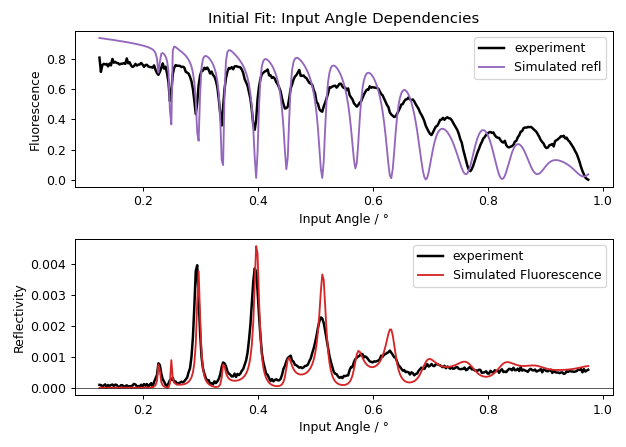

In [16]:
###################################################
##### Diode trace plots
###################################################
angles_in = xlf.rad2deg(my_problem.angles_in)
model_fluor = xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)
model_refl = np.mean(xlf.abs2(my_problem.reflectivity),0)

exp_fluor = my_problem.experiment['fluor_diode']*cavity.parameters['I_fluorescence']
exp_refl = my_problem.experiment['refl']*cavity.parameters['I_reflectivity']

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7, 5))
ax1.set_title(f'Initial Fit: Input Angle Dependencies')

plt.sca(ax1)
ax1.plot(angles_in, exp_refl, c='k', lw=2,label = 'experiment')
ax1.plot(angles_in, model_refl, 'C4-', label='Simulated refl')

plt.ylabel('Normalized Intensity / arb. u.')
plt.xlabel('Input Angle / °')
plt.ylabel('Fluorescence')
plt.legend()

plt.sca(ax2)
ax2.plot(angles_in, exp_fluor, c='k', lw=2,label = 'experiment')
ax2.plot(angles_in, model_fluor, c='C3',
         label='Simulated Fluorescence')
plt.xlabel('Input Angle / °')
plt.legend()
plt.ylabel('Reflectivity')
plt.axhline(c='k', lw=.5)
plt.tight_layout()


<IPython.core.display.Javascript object>


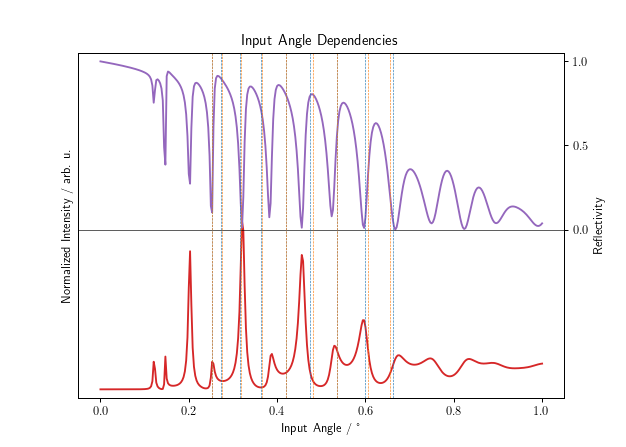

In [39]:



###################################################
##### Diode trace plots
###################################################
plt.figure(figsize=(7, 5))
ax1 = plt.gca()
plt.ylabel('Normalized Intensity / arb. u.')
plt.plot(xlf.normmax(my_problem.angles_in), xlf.abs2(my_problem.reflectivity)[0,:] * np.nan, 'C4-',
         label='Simulated Reflectivity')  # dummy plots for legend
plt.plot(xlf.normmax(my_problem.angles_in), xlf.abs2(my_problem.reflectivity)[0,:] * np.nan, 'C0--',
         label='Measured Reflectivity')

plt.plot(xlf.normmax(my_problem.angles_in), xlf.normmax(xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)), c='C3',
         label='Simulated Fluorescence')
data_shift = 0

# plt.ylim(None,6)
plt.xlabel('Input Angle / °')
plt.title(f'Input Angle Dependencies')
plt.yticks([])
plt.ylim(None, 2)

ax2 = plt.gca().twinx()
plt.plot(xlf.normmax(my_problem.angles_in), xlf.normmax(xlf.abs2(my_problem.reflectivity)[0,:]), 'C4-', label='Simulated refl')
plt.ylabel('Reflectivity')
plt.ylim(-1, None)
plt.yticks([0, 0.5, 1])
plt.axhline(c='k', lw=.5)

mode_angles = [.253, .2725, .317, .3625, .420, .474, .536, .598, .662]
for angle in mode_angles:
    plt.axvline(angle - data_shift, lw=.5, c='C0', ls='--')
mode_angles = [.253, .276, .318, .365, .420, .482, .536, .606, .655]
for angle in mode_angles:
    plt.axvline(angle - data_shift, lw=.5, c='C1', ls='--')




In [40]:
cavity.solution.incident_field_amplitude.shape

(1, 341, 143)

<IPython.core.display.Javascript object>


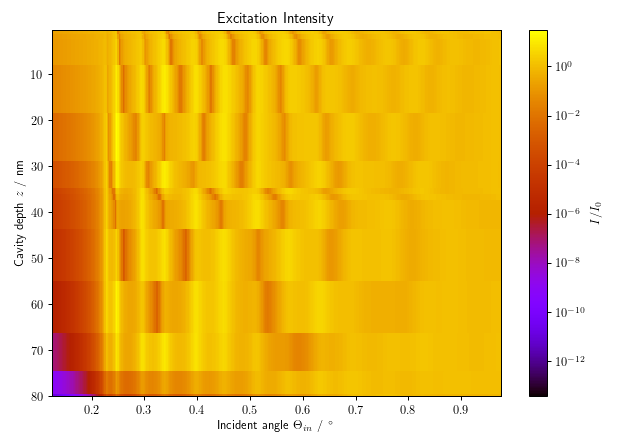

(80.0, 0.4666666666666666)

In [11]:

mpl.rcParams['text.usetex'] = True

plt.figure(figsize = (7,5))
plt.pcolormesh(xlf.rad2deg(my_problem.angles_in),my_problem.z_axis*1e9, xlf.abs2(cavity.solution.incident_field_amplitude[0,:,:]).T,\
               cmap = 'gnuplot', norm = mpl.colors.LogNorm(),shading = 'nearest')

plt.ylabel('Cavity depth $z$ / nm')
plt.xlabel('Incident angle $ { \Theta}_{in}$ / $^\circ$')
plt.title('Excitation Intensity')
plt.colorbar(label='$I / I_0$')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.ylim(80,None)


<IPython.core.display.Javascript object>


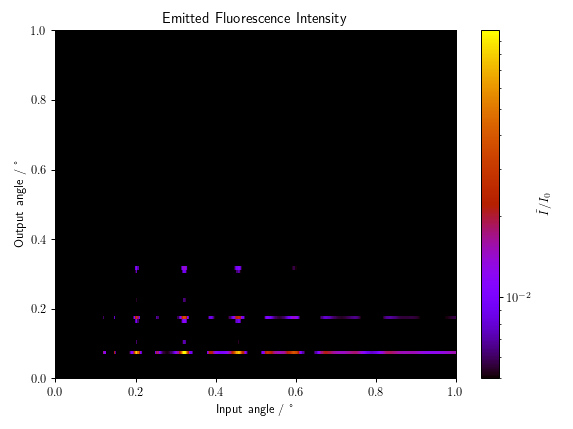

<IPython.core.display.Javascript object>


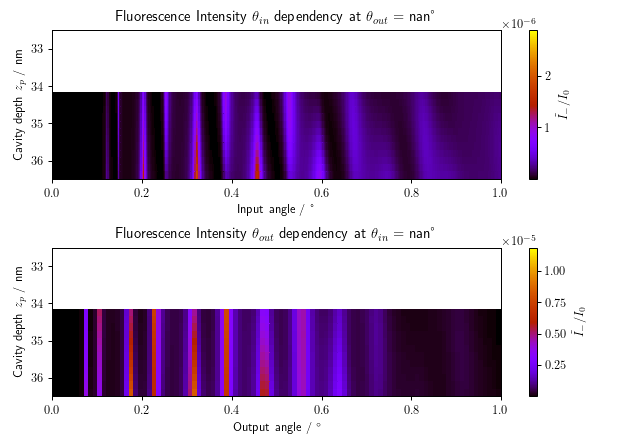

In [38]:


#####################################################
######### 2d Plot
################################################
#plotmat = xlf.abs2(cavity.solution.fluorescence_emitted_amplitude[0,0,:,:])
plotmat = xlf.abs2(np.nansum(cavity.solution.fluorescence_local_amplitude[0,0,:,:,:,0],2)) # sum over depth of non-propagated fluorescence
#plotmat = cplxsq(my_problem.fluor_emitted_from_z[:,:,:])
#plotmat = cplxsq(np.sum(my_problem.fluor_emitted_from_z[:,:,:],0))

plt.figure()
plt.pcolormesh(xlf.normmax(my_problem.angles_in),xlf.normmax(my_problem.angles_out),\
               plotmat.T,norm = mpl.colors.LogNorm(vmin = 0.005), cmap = 'gnuplot', shading = 'nearest')#,vmax=4e3)#
plt.ylabel('Output angle / °')
plt.xlabel('Input angle / °')
plt.title('Emitted Fluorescence Intensity')
plt.colorbar(label=r'$\tilde{I} / I_0$')
plt.tight_layout()


#########################################


example_angle_in = xlf.deg2rad(0.3)
example_angle_in_index = np.argmin(np.abs(example_angle_in-my_problem.angles_in))

example_angle_out = xlf.deg2rad(0.342)
example_angle_out_index = np.argmin(np.abs(example_angle_out-my_problem.angles_out))



fig, axes = plt.subplots(2,1, figsize = (7,5))
plt.sca(axes[0])
plt.pcolormesh(xlf.normmax(my_problem.angles_in),my_problem.z_axis*1e9,\
               xlf.abs2(cavity.solution.fluorescence_local_amplitude_propagated[0,0,:,example_angle_out_index,:]).T,shading = 'nearest',cmap = 'gnuplot')
plt.axvline(xlf.normmax(example_angle_in), ls = '--', lw= 1, c='grey')

plt.ylabel('Cavity depth $z_p$ / nm')
plt.xlabel('Input angle / °')
plt.title(r'Fluorescence Intensity $\theta_{in}$ dependency at $\theta_{out}$ ='+f' {xlf.normmax(my_problem.angles_out[example_angle_out_index]):.2}°')
plt.colorbar(label=r'$\tilde{I}_{-} / I_0$')
plt.gca().invert_yaxis()
plt.ylim(32.5,36.5)
plt.tight_layout()
plt.gca().invert_yaxis()

plt.sca(axes[1])
plt.pcolormesh(xlf.normmax(my_problem.angles_out),my_problem.z_axis*1e9,\
               xlf.abs2(cavity.solution.fluorescence_local_amplitude_propagated[0,0,example_angle_in_index,:,:]).T,shading = 'nearest', vmax=None,cmap = 'gnuplot')#, norm = mpl.colors.LogNorm()
plt.axvline(xlf.normmax(example_angle_out), ls = '--', lw= 1, c='grey')
plt.ylabel('Cavity depth $z_p$ / nm')
plt.xlabel('Output angle / $^\circ$')
plt.title(r'Fluorescence Intensity $\theta_{out}$ dependency at $\theta_{in}$ ='+f' {xlf.normmax(my_problem.angles_in[example_angle_in_index]):.2}°')
plt.colorbar(label=r'$\tilde{I}_{-} / I_0$')
plt.gca().invert_yaxis()
plt.ylim(32.5,36.5)
plt.tight_layout()
plt.gca().invert_yaxis()



plt.show()